In [1]:
import pandas as pd
import numpy as np
import joblib
import json
import os
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (classification_report, confusion_matrix, roc_auc_score,
                             precision_recall_curve, roc_curve, accuracy_score)


In [2]:
csv_path = "merged_lexical_clean_2.csv"
df = pd.read_csv(csv_path)

print("Dataset shape:", df.shape)

# Detect label column
label_candidates = [col for col in df.columns if col.lower() in {"label", "class", "target", "result"}]
assert label_candidates, "No label column found"
LABEL = label_candidates[0]
print("Label column:", LABEL)

# Drop unnecessary columns
exclude_cols = [LABEL, "url", "URL", "website", "dataset_source"]
X = df.drop(columns=[col for col in exclude_cols if col in df.columns], errors="ignore")
X = X.select_dtypes(include=[np.number])
y = df[LABEL].astype(int)

# Handle missing/infinite values
X.replace([np.inf, -np.inf], np.nan, inplace=True)
X.fillna(0, inplace=True)


Dataset shape: (21430, 15)
Label column: label


In [3]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)

print("Train:", X_train.shape, "Test:", X_test.shape)


Train: (17144, 14) Test: (4286, 14)


In [4]:
rf_clf = RandomForestClassifier(
    n_estimators=100,
    class_weight="balanced",
    max_depth=None,
    random_state=42,
    n_jobs=-1
)

rf_clf.fit(X_train, y_train)
print("Random Forest model trained successfully!")


Random Forest model trained successfully!


In [5]:
test_probs = rf_clf.predict_proba(X_test)[:, 1]
test_preds = rf_clf.predict(X_test)

# Metrics
roc_auc = roc_auc_score(y_test, test_probs)
acc = accuracy_score(y_test, test_preds)
cm = confusion_matrix(y_test, test_preds)
report = classification_report(y_test, test_preds, output_dict=True)

print("ROC-AUC:", roc_auc)
print("Accuracy:", acc)
print("Confusion Matrix:\n", cm)


ROC-AUC: 0.9065909060721197
Accuracy: 0.8273448436770882
Confusion Matrix:
 [[1784  359]
 [ 381 1762]]


Best F1 Threshold: 0.400 | Best F1 Score: 0.829


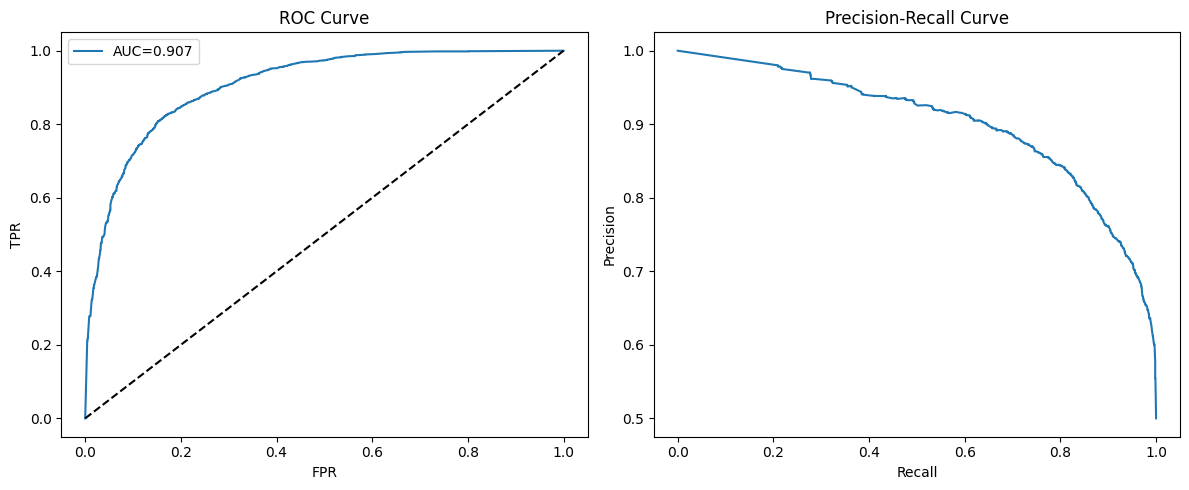

In [6]:
# Precision-Recall Curve
precisions, recalls, thresholds = precision_recall_curve(y_test, test_probs)
f1_scores = 2 * (precisions * recalls) / (precisions + recalls + 1e-12)
best_idx = np.argmax(f1_scores)
best_threshold = thresholds[best_idx]

print(f"Best F1 Threshold: {best_threshold:.3f} | Best F1 Score: {f1_scores[best_idx]:.3f}")

# ROC Curve
fpr, tpr, _ = roc_curve(y_test, test_probs)

plt.figure(figsize=(12, 5))

# ROC Curve
plt.subplot(1, 2, 1)
plt.plot(fpr, tpr, label=f"AUC={roc_auc:.3f}")
plt.plot([0, 1], [0, 1], 'k--')
plt.title("ROC Curve")
plt.xlabel("FPR")
plt.ylabel("TPR")
plt.legend()

# Precision-Recall
plt.subplot(1, 2, 2)
plt.plot(recalls, precisions)
plt.title("Precision-Recall Curve")
plt.xlabel("Recall")
plt.ylabel("Precision")

plt.tight_layout()
plt.show()


In [7]:
os.makedirs("artifacts", exist_ok=True)

joblib.dump(rf_clf, "artifacts/phishguard_rf.joblib")

with open("artifacts/phishguard_rf_report.json", "w") as f:
    json.dump(report, f, indent=2)

with open("artifacts/phishguard_rf_threshold.json", "w") as f:
    json.dump({
        "best_threshold": float(best_threshold),
        "best_f1_score": float(f1_scores[best_idx]),
        "roc_auc": float(roc_auc),
        "accuracy": float(acc)
    }, f, indent=2)

print("Model, report, and threshold saved to 'artifacts/'")


Model, report, and threshold saved to 'artifacts/'


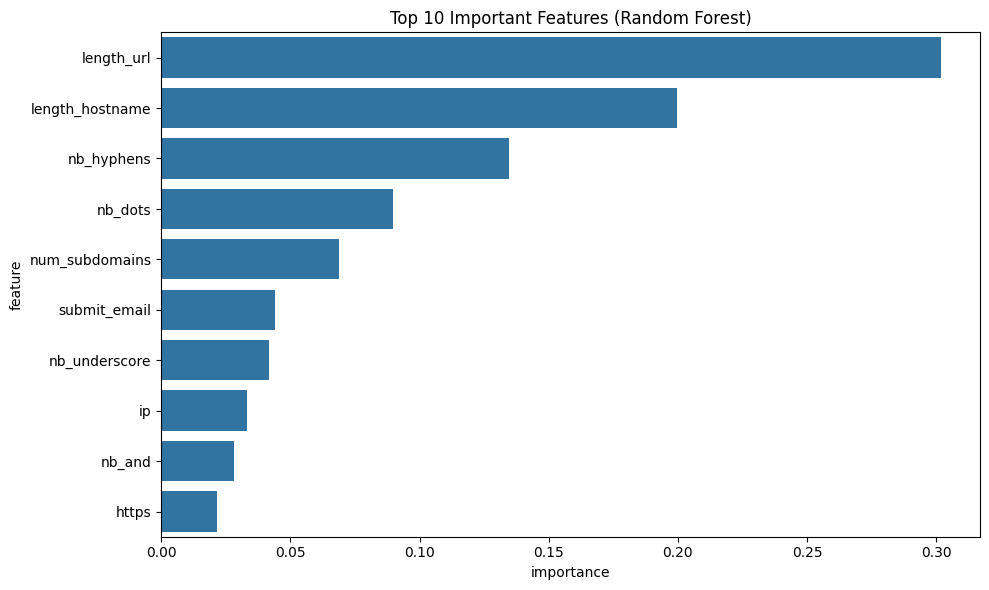

In [8]:
importances = rf_clf.feature_importances_
importance_df = pd.DataFrame({
    "feature": X.columns,
    "importance": importances
}).sort_values(by="importance", ascending=False)

plt.figure(figsize=(10, 6))
sns.barplot(x="importance", y="feature", data=importance_df.head(10))
plt.title("Top 10 Important Features (Random Forest)")
plt.tight_layout()
plt.show()
